<a href="https://colab.research.google.com/github/IsaacHgo/Clasificador-de-Gatos-o-Flores/blob/main/Te_pareces_mas_a_una_Flor_o_un_Gato_(Clasificador).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#¿Te pareces más a un gato o una flor?
Benemérita Universidad Autónoma de Puebla.

Facultad de Ciencias Físico Matemáticas.

Ciencia de datos.

*Isaac Hidago P*

# Introducción y resumen

Se quiere comprobar las capacidades de las redes neuronales para poder reconocer patrones de manera sencilla y poder clasificar dos categorías aparentemente diferentes de forma automática usando imágenes.
Esto es principalmente para un juego en el cual podremos ver si una respectiva foto o imagen tiene más parentesco con una flor o con un gato. Un juego simple que nos ayudara ver implementaciones de las redes neuronales.
Además, se quiere ver el impacto generado de un filtro de imágenes que, personalmente, me pareció curioso en internet.
Para hacer esto tenemos que pasar por todas las partes que implican generar un modelo de clasificación con imágenes y RNN por lo que tendremos que empezar con lo más esencial


In [1]:
#Librerias
import os
import random
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub
import gradio as gr

# Base de datos
Se ha elegido una base de datos en libre acceso de Kaggle. Esta contiene múltiples imágenes de personas, bicicletas, flores, gatos, etc.
Para los objetivos del problema de clasificación y debido a la curiosidad personal se ha elegido únicamente dos categorías; gatos y flores por lo que se extraerá la base de datos y en base a la ruta prevista donde se descargaran las imágenes.



In [2]:
# Primero cargamos una base de dtaos de Kaggle
# Tiene bastantes imagenes de algnas cosas como bicicletas, personas y asi
# Pero lo que nos importa es que haremos un clasificador de gatos y flores
path = kagglehub.dataset_download("pavansanagapati/images-dataset")
print("Path to dataset files:", path)
# Listamos las subcarpetas para extraer solo las imagenes que necesitamos
for root, dirs, files in os.walk(path):
    print(f"Found directory: {root}")

Using Colab cache for faster access to the 'images-dataset' dataset.
Path to dataset files: /kaggle/input/images-dataset
Found directory: /kaggle/input/images-dataset
Found directory: /kaggle/input/images-dataset/data
Found directory: /kaggle/input/images-dataset/data/horses
Found directory: /kaggle/input/images-dataset/data/cars
Found directory: /kaggle/input/images-dataset/data/dogs
Found directory: /kaggle/input/images-dataset/data/flowers
Found directory: /kaggle/input/images-dataset/data/data
Found directory: /kaggle/input/images-dataset/data/data/horses
Found directory: /kaggle/input/images-dataset/data/data/cars
Found directory: /kaggle/input/images-dataset/data/data/dogs
Found directory: /kaggle/input/images-dataset/data/data/flowers
Found directory: /kaggle/input/images-dataset/data/data/bike
Found directory: /kaggle/input/images-dataset/data/data/cats
Found directory: /kaggle/input/images-dataset/data/data/human
Found directory: /kaggle/input/images-dataset/data/bike
Found di

###Ejemplos de imagens

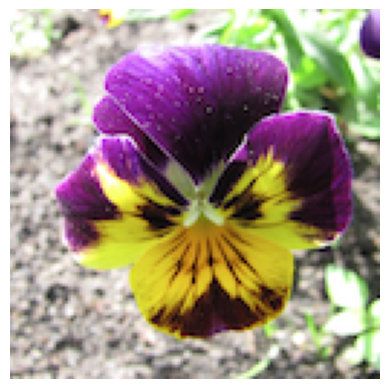

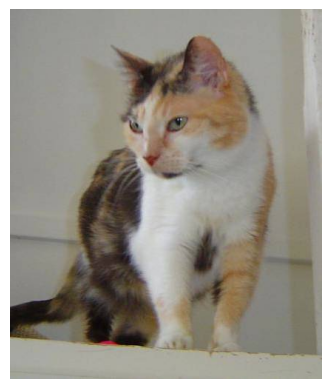

In [3]:
flower1="/root/.cache/kagglehub/datasets/pavansanagapati/images-dataset/versions/1/data/flowers"
Catos1="/root/.cache/kagglehub/datasets/pavansanagapati/images-dataset/versions/1/data/cats"
#Esto solo es un ejemplo
path = flower1#nombre de la pic
# Cargar y mostrar una imagen de ejemplo
image_path = os.path.join(path, "0130.png")#mejor se busco directamente donde está
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Ocultar los ejes
plt.show()
path = Catos1
# Cargar y mostrar una imagen de ejemplo
image_path = os.path.join(path, "cat.130.jpg")
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

### Preparación de la base de datos:
Se eligen únicamente las imágenes de gatos y flores y se les aplican diferentes filtros para usarlas en el modelo.
#### Transformación de las imágenes:
Se hacen diferentes filtros como son un cambio de escala, una normalización de los pixeles y sobre todo el filtro *UnsharpMask* que nos ayuda en teoría para reconocer bordes de patrones más concretos, véase el ejemplo siguiente:

#### Sin filtro:
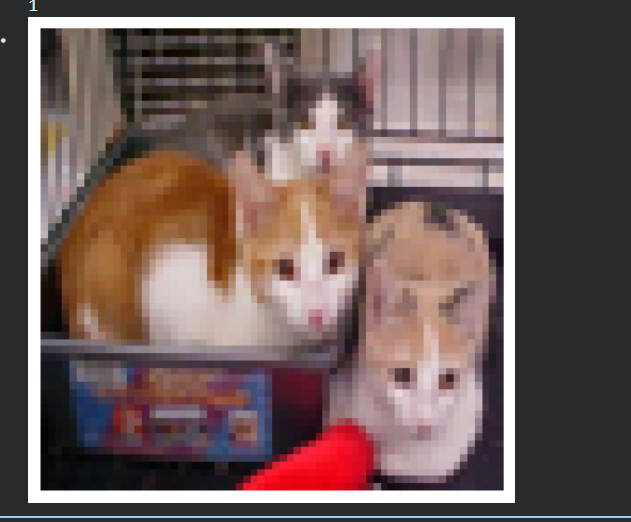

#### Con filtro:
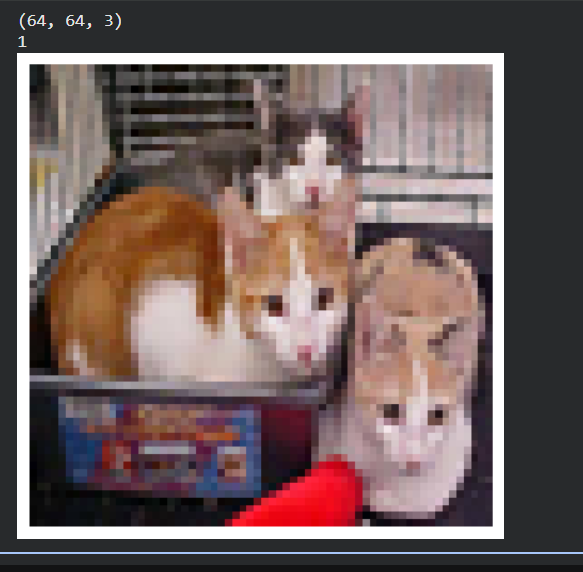.

Además, se obtiene el array de la imagen para obtener sus datos de forma más
concreta

In [5]:
def filtro_patrones(img):
    return img.filter(ImageFilter.UnsharpMask(radius=2, percent=180))
    #He ocupado este filtro para mejorar la vizualizacion de bordes en
    #las imagenes

# Rutas de las carpetas (cambia estas rutas por las tuyas)
W_gatos = Catos1
W_flores = flower1
# Función para cargar y preprocesar las imágenes
#El tamañ es mediano para que no sea poca información
Tamano=(64, 64)
def cargar_imagenes(ruta, Clase, Tamano):
    imagenes = []
    GyF = []
    for archivo in os.listdir(ruta):
        if archivo.endswith(".jpg") or archivo.endswith(".png"):  # Considera solo archivos de imagen
            #A partir de aqui, la imagen será deformada a nuestro placer como si fueramos los Qu (All Tomorrows)
            imgage = Image.open(os.path.join(ruta, archivo))
            imgage = imgage.convert("RGB")
            imgage = filtro_patrones(imgage)
            #imgage = imgage.convert('L') # Convertir a escala de grises para que mi pc no se queme y se cargen los archivos bien
            #Este filtro fue eliminado ya que se observo que a una escala de colores mi pc no se quema, ademas se obtienen mejores resultados
            imgage = imgage.resize(Tamano)# Redimensionar la imagen a lo definido
            imgageArai = np.array(imgage) # Convertir la imagen a un array
            imgageArai = imgageArai / 255.0 ## Normalizcion de los pixeles
            imagenes.append(imgageArai) # Añadir la imagen y la clasificacion al conjunto de datos
            GyF.append(Clase) #Preferí no usar filtros grandes debido a que la matriz de confusion se iba a la v
    return np.array(imagenes), np.array(GyF)

# Cargar imágenes. 1 es para gatos y 2 para flores
imagenes_gatos, GyF_gatos = cargar_imagenes(W_gatos, Clase=1,
                                            Tamano=Tamano)
imagenes_flores, GyF_flores = cargar_imagenes(W_flores, Clase=0,
                                              Tamano=Tamano)
# Unir alos datos
imagenes = np.concatenate([imagenes_gatos, imagenes_flores], axis=0)
GyF = np.concatenate([GyF_gatos, GyF_flores], axis=0)


### Ejemplo con filtro:

(64, 64, 3)
0


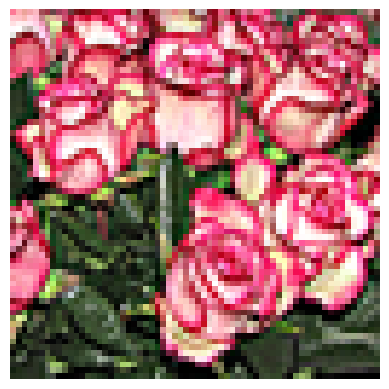

In [17]:
indices = np.arange(len(imagenes))   # [0, 1, 2, ..., N]
np.random.shuffle(indices)           # Mezcla los índices

imagenes = imagenes[indices]         # Aplica la mezcla a las imagenes
GyF = GyF[indices]


r=random.randint(0, len(imagenes))
plt.imshow(imagenes[r])
plt.axis('off')
print(imagenes[r].shape)
print(GyF[r])
plt.show()

## Generación de data
Ahora, debido a que no tenemos una base de datos gigante vamos a usar un truco conocido. Se hacen diferentes filtros o modificaciones drásticas a las imagenes para crear más información para la base de datos

#### Partición de datos
Muy aparte de lo anterior se dividen los conjuntos de entrenamiento y prueba para las métricas de evaluación de los modelos y el filtro elegido

In [18]:
# Aqui vamos más allá de los Qu y jugamos a ser dioses con las imagenes
datagen = ImageDataGenerator(
    rotation_range=40,      #Rotación aleatoria
    width_shift_range=random.uniform(0.01, 0.3),  #Desplazamiento horizontal aleatorio
    height_shift_range=random.uniform(0.01, 0.3), #Desplazamiento vertical aleatorio
    shear_range=random.uniform(0.01, 0.3),        #Corte aleatorio
    horizontal_flip=True,   #Volteo aleatorio
    fill_mode='nearest'     #Rellenar lo vacio tras la deformación
    #Sobre esto estuve pensandi mucho y vi los diferentes tipos de llenado, al final me decidi de este para no complicar con datos inecesarios el modelo
)

# Repetir las imágenes para aumentar el tamaño del dataset
Images_New = []
GyF_New = []

# Aplicar aumentación a las imágenes originales
for i in range(len(imagenes)):
    img = imagenes[i]
    Clase = GyF[i]
    # Redimensionar para usar ImageDataGenerator
    img = np.expand_dims(img, axis=0)
    # Generar las iagenes buenas.
    for _ in range(5):  # Crear 5 versiones aumentadas por imagen original
        for img_aumentada in datagen.flow(img, batch_size=1):
            Images_New.append(img_aumentada[0])
            GyF_New.append(Clase)
            break

#Esto ya se ha hecho
# Convertir arrays
Images_New = np.array(Images_New)
GyF_New = np.array(GyF_New)
# Unir las imágenes nuevas con las otras
imagenes = np.concatenate([imagenes, Images_New], axis=0)
GyF = np.concatenate([GyF, GyF_New], axis=0)
# Revolver los datos de nuevo. jsjjss Terremoto xd
indices = np.arange(imagenes.shape[0])
np.random.shuffle(indices)
# De ví que barajear cartas 7 veces hace ya una baraja aleatoria
np.random.shuffle(indices)
np.random.shuffle(indices)
# jajajaja aunque pensandolo bien con la funicíon random funciona
#Se elimina 4 barajeos

#Ordenar
imagenes = imagenes[indices]
GyF = GyF[indices]

# Dividir en conjunto de entrenamiento y prueba
imagenes_train, imagenes_test, GyF_train, GyF_test = train_test_split(
    imagenes, GyF, test_size=0.2, random_state=42)

# Verifica las dimensiones
print(imagenes_train.shape, GyF_train.shape)
print(imagenes_test.shape, GyF_test.shape)

(1977, 64, 64, 3) (1977,)
(495, 64, 64, 3) (495,)


### Pequeño ejemplo de las imagenes incluyendo la data creada

(64, 64, 3)
1


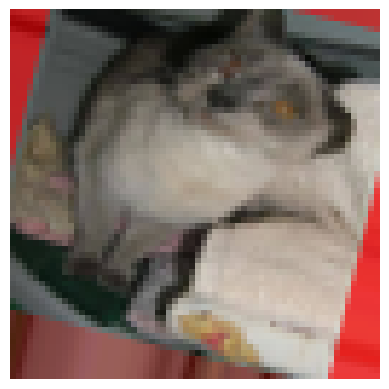

In [75]:
r=random.randint(0, 1977)
plt.imshow(imagenes[r],)
plt.axis('off')  # Opcional: ocultar los ejes
print(imagenes[r].shape)
print(GyF[r])
plt.show()

#  Analisis del modelo de redes neuronales

Se crea un modelo sencillo con un optimizador basico *adam*. Esto con el fin de clasificar nuestro modelo. De hecho se hace de pocas capas para hacerlo lo mas parsimonioso posible.



### Resumen de las capas modelo:

1. **Conv2D(64, (3,3), activation='relu', input_shape=(64,64,3))**  
   Aplica filtros para extraer características locales de la imagen RGB.

2. **MaxPooling2D((2,2))**  
   Reduce a la mitad la resolución para simplificar y destacar características importantes.

3. **Conv2D(64, (3,3), activation='relu')**  
   Aplica otros filtros.

4. **MaxPooling2D((2,2))**  
   Reduce nuevamente la resolución.

5. **Flatten()**  
   Aplana la salida 2D en un vector 1D para tener una única métrica de medición sencilla.

6. **Dense(128, activation='relu')**  
   Capa de 128 neuronas para su entrenamiento.

7. **Dense(2, activation='softmax')**  
   Capa final con 2 neuronas que genera probabilidades para cada clase.

  
### Resumen del resumen:

| Input Shape    | Descripción           | Salida / Forma                      |
| -------------- | --------------------- | ----------------------------------- |
| Imagen RGB     | Imagen de entrada     | (64, 64, 3)                         |
| Conv2D         | 64 filtros 3x3        | (62, 62, 64)                        |
| ReLU           | Función de activación |                                     |
| MaxPooling2D   | Tamaño (2, 2)         | (31, 31, 64)                        |
| Conv2D         | 64 filtros 3x3        | (29, 29, 64)                        |
| ReLU           | Función de activación |                                     |
| MaxPooling2D   | Tamaño (2, 2)         | (14, 14, 64)                        |
| Flatten        | Aplanamiento          | 14 * 14 * 64 = 12,544 neuronas      |
| Dense          | Fully Connected       | 128 neuronas                        |
| ReLU           | Función de activación |                                     |
| Dense (Salida) | Salida softmax        | 2 neuronas (Prob. Gato, Prob. Flor) |
| Clasificación  | Resultado final       | Gato o Flor                         |



<span style="font-size:4px;">(Decidí poner relu como renglon aparte por esética del codigo texto)</span>

# Modelo y entrenamiento
Debido a las capacidades de procesamiento de mi computadora se ha elegido por solo usar un 30% de la base de datos total para las pruebas de eras.
Esto puede representar un problema de sesgo, pero es lo más optimo hecho

In [31]:
train_sample_size = int(0.3 * len(imagenes_train))
test_sample_size = int(0.3 * len(imagenes_test))
indices_train = np.random.choice(len(imagenes_train), train_sample_size, replace=False)
indices_test = np.random.choice(len(imagenes_test), test_sample_size, replace=False)
imagenes_train = imagenes_train[indices_train]
GyF_train = GyF_train[indices_train]
imagenes_test = imagenes_test[indices_test]
GyF_test = GyF_test[indices_test]
print(imagenes_train.shape, GyF_train.shape)
print(imagenes_test.shape, GyF_test.shape)

(593, 64, 64, 3) (593,)
(148, 64, 64, 3) (148,)


## Elección de épocas.

Una época se considera de manera resumida cada vez que se pasan los datos tenidos a la red neuronal y se evalúa. como esta no es perfecta ajusta sus pesos con cada época extra para tener una aproximación más certera de la clasificación.

Visto lo anterior del curso. Tampoco se trata de hacer un sobre ajuste del modelo ni un procesamiento absurdo de datos. por lo que se hacen simulaciones con las métricas Accuracy y Loss error para evaluar que tanto mejora el modelo con cada época hecha. así elegir un número óptimo para mi computadora y el Accuracy.

Debido al mismo problema de datos, no es posible para la computadora hacer cientos de simulaciones así que solo se ha entrenado el modelo de forma independiente 20 veces, cada una de ellas con 20 épocas y, como antes fue mencionado, solo con un 30% de la base de datos aumentada.


### Simulaciones de entrenamiento y recopilación de resultados

In [34]:
n_replicas = 20
epochs = 20
histories = []
for i in range(n_replicas):
    print(f"\n=== Entrenamiento {i+1}/{n_replicas} ===")
    modelo = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])

    modelo.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    history = modelo.fit(
        imagenes_train, GyF_train,
        epochs=epochs,
        validation_data=(imagenes_test, GyF_test),
        verbose=0)

    histories.append(history)

# Inicializar arrays
loss_array = np.zeros((epochs,))
val_loss_array = np.zeros((epochs,))
acc_array = np.zeros((epochs,))
val_acc_array = np.zeros((epochs,))
#Sumarlos
for h in histories:
    loss_array += np.array(h.history['loss'])
    val_loss_array += np.array(h.history['val_loss'])
    acc_array += np.array(h.history['accuracy'])
    val_acc_array += np.array(h.history['val_accuracy'])
#Dividirlos para promediar
loss_avg = loss_array / n_replicas
val_loss_avg = val_loss_array / n_replicas
acc_avg = acc_array / n_replicas
val_acc_avg = val_acc_array / n_replicas
plt.figure(figsize=(12,5))



=== Entrenamiento 1/20 ===

=== Entrenamiento 2/20 ===

=== Entrenamiento 3/20 ===

=== Entrenamiento 4/20 ===

=== Entrenamiento 5/20 ===

=== Entrenamiento 6/20 ===

=== Entrenamiento 7/20 ===

=== Entrenamiento 8/20 ===

=== Entrenamiento 9/20 ===

=== Entrenamiento 10/20 ===

=== Entrenamiento 11/20 ===

=== Entrenamiento 12/20 ===

=== Entrenamiento 13/20 ===

=== Entrenamiento 14/20 ===

=== Entrenamiento 15/20 ===

=== Entrenamiento 16/20 ===

=== Entrenamiento 17/20 ===

=== Entrenamiento 18/20 ===

=== Entrenamiento 19/20 ===

=== Entrenamiento 20/20 ===


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

## Resultados de la simaulción

Despues devarias iteraciones tenemos resultados promedio de entre 4, 6 y 7 valores. Gracias a esto podemos promediar **5** Épocas para tener un resultado aceptable


Época donde loss se estabiliza: 5
Época donde val_loss se estabiliza: 6
Época donde acc se estabiliza: 5
Época donde val_acc se estabiliza: 4


<Figure size 1200x500 with 0 Axes>

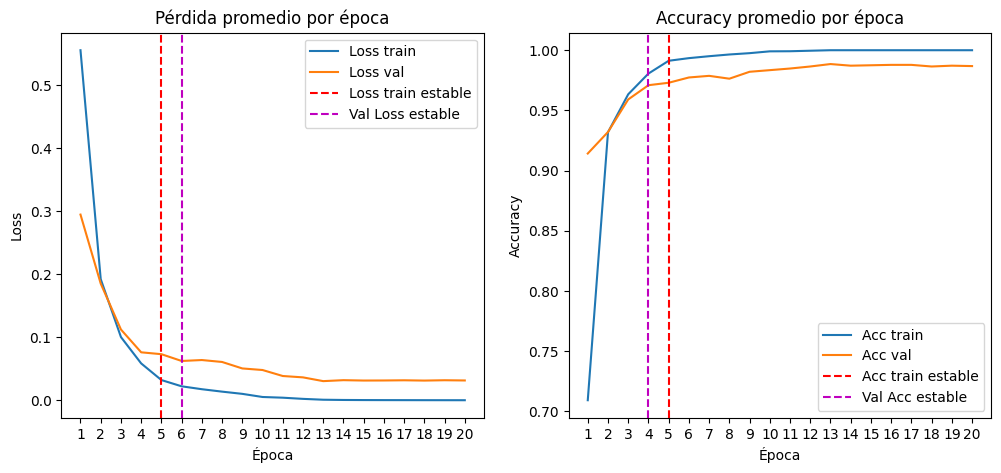

In [35]:
#Funición de parada
def encontrar_epoca_estable(metrica, umbral=0.01, min_epocas=3):
    for i in range(len(metrica) - min_epocas + 1):
        diffs = np.abs(np.diff(metrica[i:i+min_epocas]))
        if np.all(diffs < umbral):
            return i + 1 #Es pq inicia en 0 y python
    return len(metrica)  #si ya no hay estabilizacion devolver el ultimo valor


epoca_loss = encontrar_epoca_estable(loss_avg)
epoca_val_loss = encontrar_epoca_estable(val_loss_avg)
epoca_acc = encontrar_epoca_estable(acc_avg)
epoca_val_acc = encontrar_epoca_estable(val_acc_avg)

print("Época donde loss se estabiliza:", epoca_loss)
print("Época donde val_loss se estabiliza:", epoca_val_loss)
print("Época donde acc se estabiliza:", epoca_acc)
print("Época donde val_acc se estabiliza:", epoca_val_acc)

plt.figure(figsize=(12,5))

plt.figure(figsize=(12,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), loss_avg, label='Loss train')
plt.plot(range(1, epochs+1), val_loss_avg, label='Loss val')
plt.axvline(epoca_loss, color='r', linestyle='--', label='Loss train estable')
plt.axvline(epoca_val_loss, color='m', linestyle='--', label='Val Loss estable')
plt.title("Pérdida promedio por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.xticks(range(1, epochs+1, 1))

# Accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), acc_avg, label='Acc train')
plt.plot(range(1, epochs+1), val_acc_avg, label='Acc val')
plt.axvline(epoca_acc, color='r', linestyle='--', label='Acc train estable')
plt.axvline(epoca_val_acc, color='m', linestyle='--', label='Val Acc estable')
plt.title("Accuracy promedio por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.xticks(range(1, epochs+1, 1))

plt.show()

# Modelo
Se selecciona el 100% de la base de datos

Se pone en trabajo el entrenamiento de la red neuronal y se evalúa finalmente.

*Además se agrega un método interactivo de evaluación* (el juego)

In [36]:
train_sample_size = int(1 * len(imagenes_train))
test_sample_size = int(1 * len(imagenes_test))
indices_train = np.random.choice(len(imagenes_train), train_sample_size, replace=False)
indices_test = np.random.choice(len(imagenes_test), test_sample_size, replace=False)
imagenes_train = imagenes_train[indices_train]
GyF_train = GyF_train[indices_train]
imagenes_test = imagenes_test[indices_test]
GyF_test = GyF_test[indices_test]
print(imagenes_train.shape, GyF_train.shape)
print(imagenes_test.shape, GyF_test.shape)

(593, 64, 64, 3) (593,)
(148, 64, 64, 3) (148,)


In [37]:
# Modelo
modelo = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])

#Compilar, siempre quise decir eso asoaksjaskj
modelo.compile(optimizer='AdamW', #Este optimizador es el que mejor me ha resultado y pq no quiero un sobre ajuste
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Entrenar el modelo con las épocas dichas
modelo.fit(imagenes_train, GyF_train, epochs=5, validation_data=(imagenes_test, GyF_test))

Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.5480 - loss: 0.7591 - val_accuracy: 0.8649 - val_loss: 0.3650
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.9197 - loss: 0.2399 - val_accuracy: 0.8378 - val_loss: 0.3562
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.9018 - loss: 0.2462 - val_accuracy: 0.8649 - val_loss: 0.3050
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.9405 - loss: 0.1466 - val_accuracy: 0.9189 - val_loss: 0.1950
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.9770 - loss: 0.0778 - val_accuracy: 0.9797 - val_loss: 0.0506


#Evaluación

#### Accuracy
Se obtiene un buen nivel de porcentaje

In [38]:
loss, accuracy = modelo.evaluate(imagenes_test, GyF_test)
print(f"Precisión del modelo: {accuracy * 100:.2f}%",  "Bueno... no está mal no?")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9781 - loss: 0.0485
Precisión del modelo: 97.97% Bueno... no está mal no?


#### Matriz de confusión

Se obtiene una matriz descendente de confusión

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


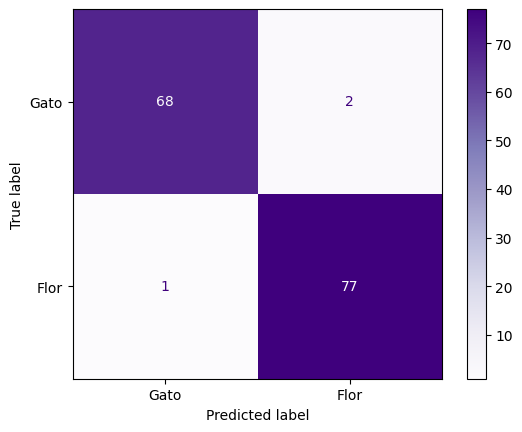

In [39]:
# Mostrar la matriz con GyF
predicciones = modelo.predict(imagenes_test)
clases_predichas = np.argmax(predicciones, axis=1)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz = confusion_matrix(GyF_test, clases_predichas)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz,
                            display_labels=["Gato", "Flor"])
disp.plot(cmap='Purples')

### Conclusión:
Tenemos en general un buen modelo que ha captado los datos necesarios para la clasificación de manera suficientemente satisfactoria para poder usarla en lo debido. Ahora se pueden hacer criticas constructivas como lo que es la problemática de la capacidad del computador usado, ya que, eso ha impedido hacer simulaciones más complejas, así como la utilización del promedio como convergencia para el número de épocas cuando pudimos haber usado otras métricas.
también se ha querido obtener un modelo más realista, pero nuestras metricas siempre daban del 99% promedio por lo que se tiene que hacer una revisión más a profundidad en busca de un posible sobre ajuste.
Aún con todo esto el modelo ha sido funcional y sirve para el propósito antes dicho ya que se logró obtener resultados buenos con el filtro dado y al final podemos tener nuestro pequeño juego.



#Juego:
#Prueba tu imagen (debes de correr el codigo para hacerlo)

In [40]:
def predecir_imagen(imagen):
    img = imagen.resize((64, 64))
    img = img.convert("RGB")
    img = filtro_patrones(img)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediccion = modelo.predict(img_array)
    clase = np.argmax(prediccion)
    return "Creo que esto es un gato 🐱" if clase == 1 else "Creo que esto es una flor 🌸"

# Esto es el diablo de programar
theme_morado = gr.themes.Soft(
    primary_hue=gr.themes.colors.purple,
    secondary_hue=gr.themes.colors.purple,
)
with gr.Blocks(theme=theme_morado) as demo:
    gr.Markdown("## ¿A qué se parece más? ¿Gato o Flor?")
    with gr.Row():
        inp = gr.Image(type="pil", label="Sube una imagen")

        with gr.Column(elem_id="col-der"):
            out = gr.Textbox(label="", elem_id="output-text")
            btn = gr.Button("PROBAR", variant="primary")
    btn.click(predecir_imagen, inp, out)
demo.launch(debug=True)

/tmp/ipython-input-552466203.py:16: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=theme_morado) as demo:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://43c7f5a34cf32562b2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://43c7f5a34cf32562b2.gradio.live


### Ejemplo de visualizacion:

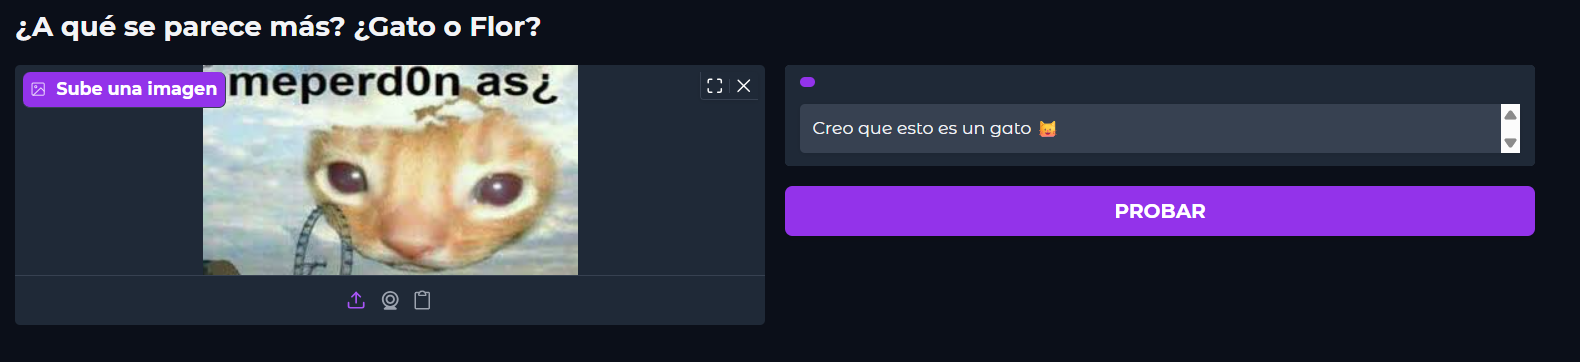

Esta imagen inspiró el juego

### Citas:
1. *Checking your browser - reCAPTCHA. (s. f.). https://www.kaggle.com/datasets/pavansanagapati/images-dataset*

2. *3.9. Máscara de desenfoque. (s. f.). https://docs.gimp.org/2.6/es/plug-in-unsharp-mask.html*

2. *Wiki, C. T. L. (s. f.). Meperd0n as¿. Loquendo Wiki. https://loquendo.fandom.com/es/wiki/Meperd0n_as%C2%BF*